### **[강화 학습] Reinforcement Learning - Assignment #1**
# **Temporal Difference Policy Evaluation in Blackjack Environment**

**(마감일: 2020년 10월 19일 오전 12:00시) - (2019 55718 - MELIA PUTRI H)**

### **Gym Libraries**
> Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding

### **BlackJack Environment**

In [ ]:
def cmp(a,b):
  return float(a>b)-float(a<b)

In [ ]:
#1=Ace, 2-10=Number Cards, Jack/Queen/King=10
deck=[1,2,3,4,5,6,7,8,9,10,10,10,10]

In [ ]:
def draw_card(np_random):
  return int(np_random.choice(deck))

In [ ]:
def draw_hand(np_random):
  return [draw_card(np_random),draw_card(np_random)]

In [ ]:
#Does this hand have a usable Ace card?
def usable_ace(hand):
  return 1 in hand and sum(hand)+10<=21

In [ ]:
#Return the current hand total
def sum_hand(hand):
  if usable_ace(hand):
    return sum(hand)+10
  return sum(hand)

In [ ]:
#Is this hand a bust?
def is_bust(hand):
  return sum_hand(hand)>21

In [ ]:
#What is the score of this hand (0 if bust)?
def score(hand):
  return 0 if is_bust(hand) else sum_hand(hand)

In [ ]:
#Is this hand a natural Black Jack? (21)
def is_natural(hand):
  return sorted(hand)==[1,10] #Cards are an Ace and a 10, Jack, Queen, or King

In [ ]:
class BlackJackEnv(gym.Env):
  def __init__(self,natural=False):
    self.action_space=spaces.Discrete(2)
    self.observation_space=spaces.Tuple((spaces.Discrete(32),
                                         spaces.Discrete(11),
                                         spaces.Discrete(2)))
    self.seed()

    #Flag to payout 1.5 on a "natural" Black Jack Win, like casino rules
    self.natural=natural

    #Start the First Game
    self.reset()

  def seed(self,seed=None):
    self.np_random,seed=seeding.np_random(seed)
    return [seed]
  
  def step(self,action):
    assert self.action_space.contains(action)
    #HIT: Add a card to players hand and return
    if action:
      self.player.append(draw_card(self.np_random))
      if is_bust(self.player):
        done=True
        reward=-1.
      else:
        done=False
        reward=0.
    #STICK: Play out the dealers hand, and score
    else:
      done=True
      while sum_hand(self.dealer)<17:
        self.dealer.append(draw_card(self.np_random))
      reward=cmp(score(self.player),score(self.dealer))
      if self.natural and is_natural(self.player) and reward==1.:
        reward=1.5
    return self._get_obs(),reward,done,{}
  
  def _get_obs(self):
    return(sum_hand(self.player),self.dealer[0],usable_ace(self.player))
  
  def reset(self):
    self.dealer=draw_hand(self.np_random)
    self.player=draw_hand(self.np_random)
    return self._get_obs()

### **BlackJack with Temporal Difference Policy (REVISION)**

**Let's Compare the Equations in Monte Carlo and Temporal Difference**

**NOTES: In TD, there is no return, so no need to code the G_t**

* **[Monte Carlo] $V(S_t)$ Updates**
  * $V(S_t) + α(G_t-V(S_t))$
* **[Temporal Difference] $V(S_t)$ Updates**
  * $V(S_t) + α(R_{t+1} + γV(S_{t+1})-V(S_t))$

In [ ]:
#import env_blackjack 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
env=BlackJackEnv()
V=np.zeros((2,10,10)) #Empirical V Values | 2 --> Usable Ace | 10 --> ... | 10 --> Dealer Number from 1 to 10
gamma=1               #Discount Factor
alpha=0.01            #Learning Rate

In [ ]:
num_episodes=500000

In [ ]:
def state_idx(state):
  return state[2]*1,state[0]-12,state[1]-1

In [ ]:
def policy(state):
  action=1
  if state[0]>=20:
    action=0
  return action

In [ ]:
winning_counter=0
for epi in range(num_episodes):
  state=env.reset()
  done=False #Indicates whether the game is done or not

  while state[0]<12:
    state,_,done,_=env.step(1)
  
  while done==False:
    action=policy(state) 
    next_state,reward,done,_=env.step(action)
    if state_idx(next_state)[1]<10:
      V[state_idx(state)]+=alpha*(reward+gamma*V[state_idx(next_state)]-V[state_idx(state)])
    elif state_idx(next_state)[1]>=10:
      V[state_idx(state)]+=alpha*(reward-V[state_idx(state)])
    
    state=next_state
    
  winning_counter+=(reward>0)*1.0

  if (epi+1)%10000==0:
    print("Episode: %6d, Winning Rate: %.3f"%(epi+1,winning_counter/(epi+1)))
    print("State:",state)
    print("Reward:",reward)

Episode:  10000, Winning Rate: 0.291
State: (26, 1, False)
Reward: -1.0
Episode:  20000, Winning Rate: 0.291
State: (20, 8, True)
Reward: 1.0
Episode:  30000, Winning Rate: 0.292
State: (26, 8, False)
Reward: -1.0
Episode:  40000, Winning Rate: 0.292
State: (20, 9, False)
Reward: 1.0
Episode:  50000, Winning Rate: 0.291
State: (27, 2, False)
Reward: -1.0
Episode:  60000, Winning Rate: 0.292
State: (28, 1, False)
Reward: -1.0
Episode:  70000, Winning Rate: 0.293
State: (21, 1, True)
Reward: 0.0
Episode:  80000, Winning Rate: 0.293
State: (20, 10, False)
Reward: 1.0
Episode:  90000, Winning Rate: 0.293
State: (28, 1, False)
Reward: -1.0
Episode: 100000, Winning Rate: 0.293
State: (21, 6, True)
Reward: 1.0
Episode: 110000, Winning Rate: 0.293
State: (28, 6, False)
Reward: -1.0
Episode: 120000, Winning Rate: 0.293
State: (20, 10, True)
Reward: 1.0
Episode: 130000, Winning Rate: 0.293
State: (21, 9, False)
Reward: 1.0
Episode: 140000, Winning Rate: 0.293
State: (21, 9, False)
Reward: 0.0
Ep

In [ ]:
X=np.arange(1,11)
Y=np.arange(12,22)
X,Y=np.meshgrid(X,Y)

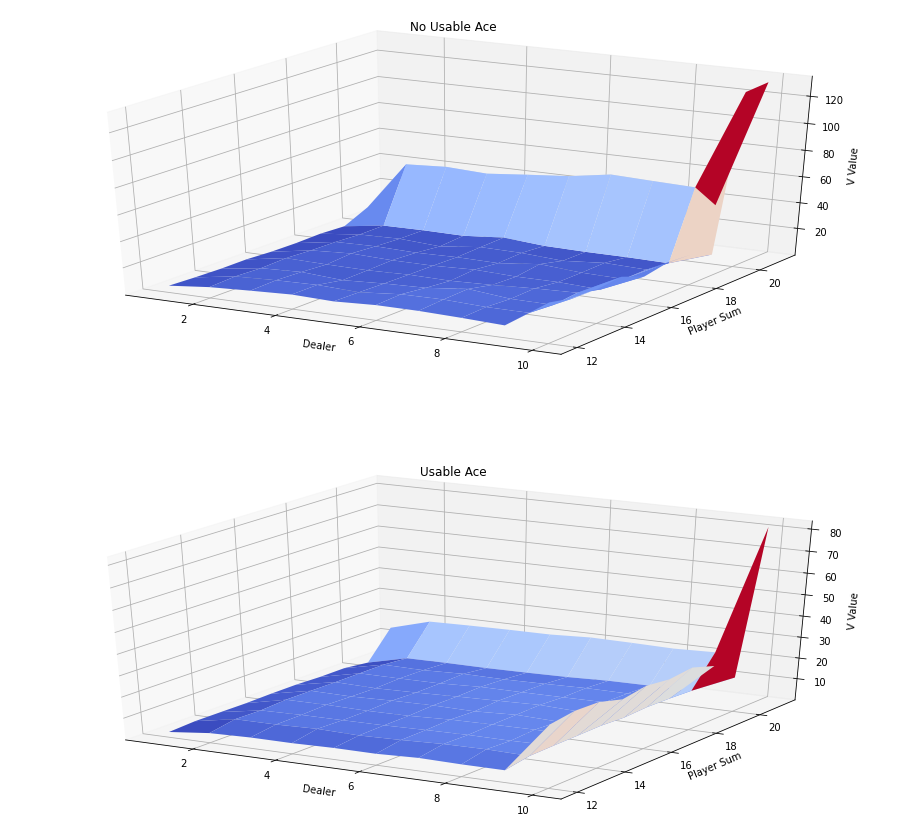

In [ ]:
fig=plt.figure(figsize=(16,15))

ax0=fig.add_subplot(211,projection='3d')
ax0.plot_surface(X,Y,V[0],rstride=1,cstride=1,cmap='coolwarm')
ax0.set_xlabel('Dealer')
ax0.set_ylabel('Player Sum')
ax0.set_zlabel('V Value')
ax0.set_title('No Usable Ace')

ax1=fig.add_subplot(212,projection='3d')
ax1.plot_surface(X,Y,V[1],rstride=1,cstride=1,cmap='coolwarm')
ax1.set_xlabel('Dealer')
ax1.set_ylabel('Player Sum')
ax1.set_zlabel('V Value')
ax1.set_title('Usable Ace')

plt.show()

### **BlackJack with Temporal Difference Policy**

**Let's Compare the Equations in Monte Carlo and Temporal Difference**

**NOTES: In TD, there is no return, so no need to code the G_t**

* **[Monte Carlo] $V(S_t)$ Updates**
  * $V(S_t) + α(G_t-V(S_t))$
* **[Temporal Difference] $V(S_t)$ Updates**
  * $V(S_t) + α(R_{t+1} + γV(S_{t+1})-V(S_t))$

In [ ]:
#import env_blackjack 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
env=BlackJackEnv()
V=np.zeros((2,10,10)) #Empirical V Values
N=np.zeros((2,10,10)) #Number of Visits
gamma=1               #Discount Factor

In [ ]:
num_episodes=500000

In [ ]:
def state_idx(state):
  return state[2]*1,state[0]-12,state[1]-1

In [ ]:
def policy(state):
  action=1
  if state[0]>=20:
    action=0
  return action

In [ ]:
winning_counter=0

for epi in range(num_episodes):
  state=env.reset()
  done=False
  state_history=[]
  reward_history=[]

  while state[0]<12:
    state,_,done,_=env.step(1)
  
  while done==False:
    action=policy(state)
    next_state,reward,done,_=env.step(action)
    state_history.append(state)
    reward_history.append(reward)
    state=next_state
  winning_counter+=(reward>0)*1.0

  T=len(state_history)
  #alpha=1
  alpha=0.0003

  for t in range(T):
    #Return in MC:
    #G_t=np.sum(np.array(reward_history[t:T])*gamma**np.arange(T-t))
    #But in Temporal Difference, there is no G_t
    #So, we directly go:

    #Index in MC:
    #index=state_idx(state_history[t])

    #Index in TD:
    index=state_idx(state_history[t-1])
    indexplus1=state_idx(state_history[t])

    #Update V(s) incrementally after episode, in MC:
    #N[index]=N[index]+1
    #V[index]=V[index]+(1/N[index]*alpha*((G_t-V[index])))

    #In TD, there is no updating N, only updating V:
    V[index]=V[index]+alpha*(reward_history[t]+gamma*V[indexplus1]-V[index])


  if (epi+1)%10000==0:
    print("Episode: %6d, Winning Rate: %.3f"%(epi+1,winning_counter/(epi+1)))

Episode:  10000, Winning Rate: 0.291
Episode:  20000, Winning Rate: 0.291
Episode:  30000, Winning Rate: 0.291
Episode:  40000, Winning Rate: 0.291
Episode:  50000, Winning Rate: 0.292
Episode:  60000, Winning Rate: 0.292
Episode:  70000, Winning Rate: 0.293
Episode:  80000, Winning Rate: 0.293
Episode:  90000, Winning Rate: 0.292
Episode: 100000, Winning Rate: 0.293
Episode: 110000, Winning Rate: 0.293
Episode: 120000, Winning Rate: 0.293
Episode: 130000, Winning Rate: 0.293
Episode: 140000, Winning Rate: 0.293
Episode: 150000, Winning Rate: 0.293
Episode: 160000, Winning Rate: 0.293
Episode: 170000, Winning Rate: 0.293
Episode: 180000, Winning Rate: 0.293
Episode: 190000, Winning Rate: 0.294
Episode: 200000, Winning Rate: 0.294
Episode: 210000, Winning Rate: 0.294
Episode: 220000, Winning Rate: 0.293
Episode: 230000, Winning Rate: 0.293
Episode: 240000, Winning Rate: 0.294
Episode: 250000, Winning Rate: 0.293
Episode: 260000, Winning Rate: 0.293
Episode: 270000, Winning Rate: 0.294
E

In [ ]:
X=np.arange(1,11)
Y=np.arange(12,22)
X,Y=np.meshgrid(X,Y)

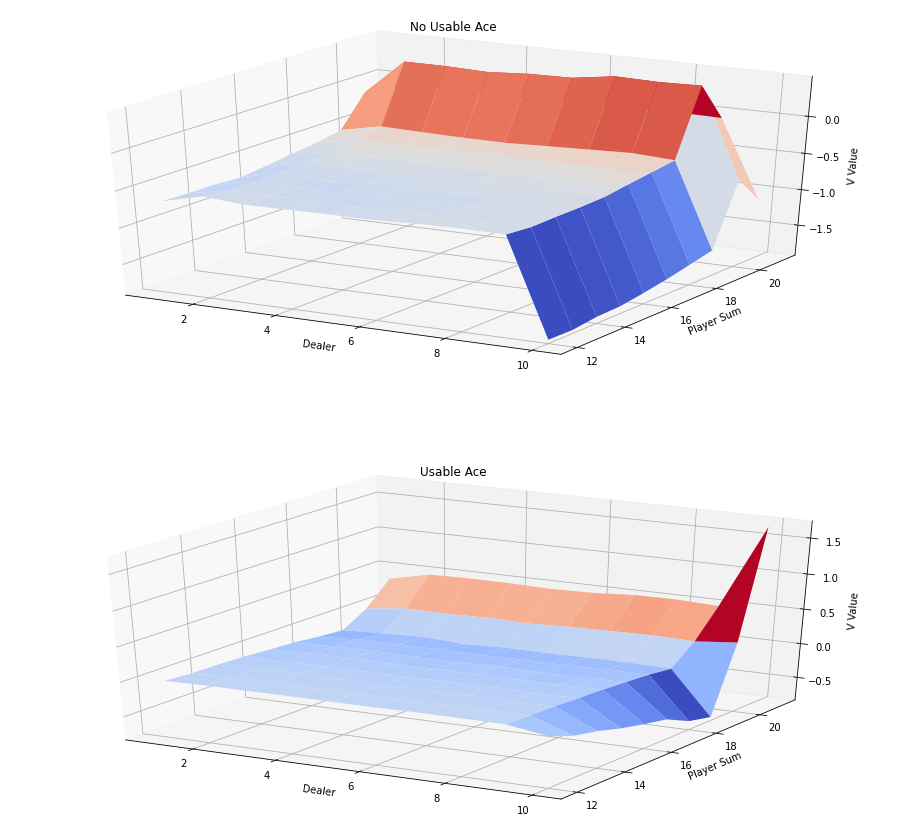

In [ ]:
fig=plt.figure(figsize=(16,15))

ax0=fig.add_subplot(211,projection='3d')
ax0.plot_surface(X,Y,V[0],rstride=1,cstride=1,cmap='coolwarm')
ax0.set_xlabel('Dealer')
ax0.set_ylabel('Player Sum')
ax0.set_zlabel('V Value')
ax0.set_title('No Usable Ace')

ax1=fig.add_subplot(212,projection='3d')
ax1.plot_surface(X,Y,V[1],rstride=1,cstride=1,cmap='coolwarm')
ax1.set_xlabel('Dealer')
ax1.set_ylabel('Player Sum')
ax1.set_zlabel('V Value')
ax1.set_title('Usable Ace')

plt.show()

In [ ]:
V.shape

(2, 10, 10)